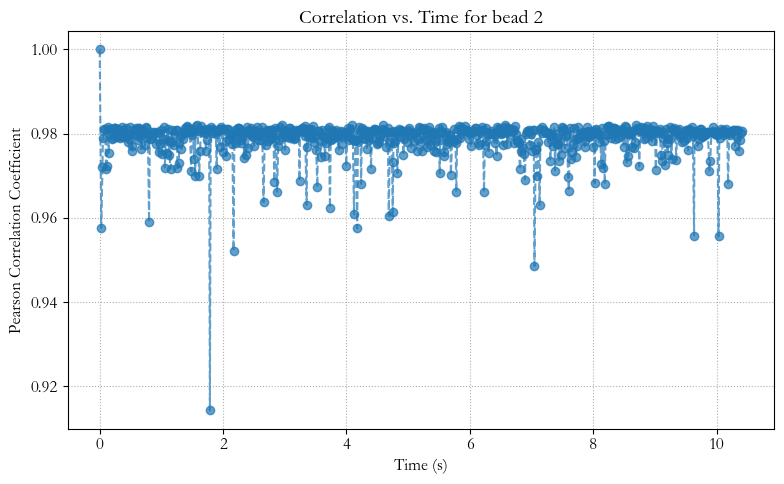

In [4]:
#此文件请注意修改对应的文件路径和正则表达式

# 导入必要的库
import os  # 文件路径操作
import re  # 正则表达式
import numpy as np  # 数值计算
import pandas as pd  # 数据结构处理
import matplotlib.pyplot as plt  # 数据可视化
from PIL import Image  # 图像处理
from scipy.fft import fft2, fftshift  # 快速傅里叶变换
from scipy.stats import pearsonr  # 皮尔逊相关系数计算

# ------------------ 数据准备阶段 ------------------

def classify_and_sort_files(base_path):
    # 修改正则表达式模式
    moving_pattern = re.compile(r'0_(\d+)nm')  # 直接匹配下划线与nm之间的数字
    ref_pattern = re.compile(r'0_(\d+)nm')
    
    # 修改数据结构：移除时间戳
    moving_beads = []
    ref_beads = []
    
    for fname in os.listdir(base_path):
        file_path = os.path.join(base_path, fname)
        # 从文件名提取位置数字
        if moving_match := moving_pattern.search(fname):
            position = int(moving_match.group(1))
            moving_beads.append((position, fname))
        elif ref_match := ref_pattern.search(fname):
            position = int(ref_match.group(1))
            ref_beads.append((position, fname))
    
    # 按位置数字排序
    moving_sorted = sorted(moving_beads, key=lambda x: x[0])
    ref_sorted = sorted(ref_beads, key=lambda x: x[0])
    
    # 调整返回值
    moving_files = [f[1] for f in moving_sorted]
    positions = [f[0] for f in moving_sorted]  # 新增位置列表
    return moving_files, positions  # 简化返回值

# 使用示例
base_path = r"D:\bead image\2pN_bead images\2pN-bead-image\2pN-bead-image"
moving_files, positions = classify_and_sort_files(base_path)
files=moving_files
# ------------------ 参考图像处理 ------------------
# 加载参考图像（假设最低的位置为焦平面）
ref_filename = moving_files[0]  # 或者其他合适的参考图像文件名
ref_img = Image.open(os.path.join(base_path, ref_filename)).convert("L")  # 转换为灰度图

# 确定所有图像的最小公共尺寸（确保后续FFT尺寸一致）
# 收集所有图像的尺寸（注意size[::-1]将PIL的(width, height)转换为(height, width)
shapes = [Image.open(os.path.join(base_path, f)).convert("L").size[::-1] for f in files]
min_shape = (min(s[0] for s in shapes), min(s[1] for s in shapes))  # (最小高度, 最小宽度)

# 裁剪参考图像至公共尺寸并进行FFT
ref_img_cropped = np.array(ref_img)[:min_shape[0], :min_shape[1]]  # 高度方向裁剪
ref_fft = fftshift(fft2(ref_img_cropped))  # 执行FFT并移动低频分量到中心

# ------------------ 频域滤波处理 ------------------
def high_pass_filter(img_fft, threshold_ratio=0.05):
    """
    高通滤波器函数（移除低频背景）
    参数：
        img_fft: 输入图像的FFT频谱
        threshold_ratio: 截止半径比例（相对于图像短边）
    返回：
        滤波后的频域信号
    """
    h, w = img_fft.shape
    cx, cy = w // 2, h // 2  # 频谱中心坐标
    radius = int(min(cx, cy) * threshold_ratio)  # 计算截止半径
    
    # 创建距离矩阵（每个点到中心的欧氏距离）
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - cx) ** 2 + (Y - cy) ** 2)
    
    # 生成布尔掩膜（保留高频部分）
    mask = dist_from_center >= radius
    return img_fft * mask  # 应用掩膜

# 对参考图像频谱进行滤波
ref_fft_filtered = high_pass_filter(ref_fft)

# ------------------ 数据特征提取 ------------------
# ... 前面的代码保持不变 ...

# ------------------ 数据特征提取 ------------------
def extract_position(fname):
    """从文件名提取位置数字"""
    match = re.search(r'0_(\d+)nm', fname)
    return int(match.group(1)) if match else None

# ------------------ 核心分析流程 ------------------
# ------------------ 核心分析流程 ------------------ 
results = []
for fname in files:
    # 1. 加载并预处理图像
    img = Image.open(os.path.join(base_path, fname)).convert("L")
    img_cropped = np.array(img)[:min_shape[0], :min_shape[1]]
    
    # 2. 频域变换与滤波（新增滤波步骤）
    img_fft = fftshift(fft2(img_cropped))
    img_fft_filtered = high_pass_filter(img_fft)  # ← 这是新增的关键步骤
    
    # 3. 计算与参考图像的相关系数（现在使用滤波后的频谱）
    r_value, _ = pearsonr(ref_fft_filtered.flatten().real, 
                        img_fft_filtered.flatten().real)  # ← 使用滤波后的img_fft
    
    # 4. 记录结果
    position = extract_position(fname)
    if position is not None:
        results.append((position, r_value))

# ------------------ 结果可视化 ------------------
# 按时间排序结果
results.sort(key=lambda x: x[0])  # 按位置数字排序
if len(results) > 0:
    first_position = results[0][0]
    results = [((pos - first_position)/1000, r_value) for pos, r_value in results]
df_results = pd.DataFrame(results, columns=["Time (s)", "Pearson r"])

plt.figure(figsize=(8, 5))
plt.plot(df_results["Time (s)"], df_results["Pearson r"], 
        marker='o', linestyle='--', alpha=0.7)
plt.title("Correlation vs. Time for bead 2")  # 修改标题
plt.xlabel("Time (s)")  # X轴标签修改
plt.ylabel("Pearson Correlation Coefficient")
plt.grid(True, linestyle=':')
plt.tight_layout()
plt.show()